In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

# Исследование базы данных сервиса Stack Overflow

- [Описание проекта](#project_description)
- [Подключение к базе данных](#connection)
- [Задания](#tasks)
    - [Задание 1](#task_1)
    - [Задание 2](#task_2)
    - [Задание 3](#task_3)
    - [Задание 4](#task_4)
    - [Задание 5](#task_5)
    - [Задание 6](#task_6)
    - [Задание 7](#task_7)
    - [Задание 8](#task_8)
    - [Задание 9](#task_9)
    - [Задание 10](#task_10)
- [Общий вывод](#general_conclusion)

## Описание проекта <a name='project_description'></a>

Проект состоит из 10 SQL-запросов к базе данных Stack Overflow.

В базе данных хранятся данные о постах за 2008 год, но в таблицах есть информацию и о более поздних оценках, которые эти посты получили.

## Подключение к базе данных <a name='connection'></a>

In [2]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

## Задания <a name='tasks'></a>

### Задание 1 <a name='task_1'></a>

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [3]:
query_1 = '''
SELECT
    DATE_TRUNC('month', creation_date) AS month_date,
    SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY month_date
ORDER BY total_views DESC
'''

pd.read_sql_query(query_1, con=engine) 

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Летом наименьшее количество просмотров, которое возрастает с каждым месяцем. В сентябре пик просмотров постов, скорее всего это связано с началом учебы. Далее количество просмотров постов постепенно уменьшается. Это можно объяснить тем, что сбор данных обрывается в декабре. Посты за сентябрь включают просмотры за 4 месяца, а посты за декабрь – за 1 месяц.

### Задание 2 <a name='task_2'></a>

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [4]:
query_2 = '''
SELECT
    u.display_name,
    COUNT(DISTINCT u.id)
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE pt.type = 'Answer' 
    AND p.creation_date >= u.creation_date AND p.creation_date <= u.creation_date + INTERVAL '1 month'
GROUP BY u.display_name
HAVING COUNT(u.id) > 100
ORDER BY u.display_name
'''

res_2 = pd.read_sql_query(query_2, con=engine)
res_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


In [5]:
res_2[res_2['count'] != 1]

,display_name,count
4,Alan,8
7,Brian,15
10,Chris,29
12,Craig,10
14,Dan,21
21,Greg,12
25,Jim,7
26,Joe,9
33,Josh,16
34,Keith,5


Некоторые пользователи указывали имя без фамилии, что и привело к большому количеству уникальных пользователей на одно имя пользователя.

### Задание 3 <a name='task_3'></a>

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [6]:
query_3 = '''
SELECT 
    DATE_TRUNC('month', p.creation_date) AS month,
    COUNT(*)
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
WHERE u.id IN (
    SELECT DISTINCT u.id
    FROM stackoverflow.users AS u
    JOIN stackoverflow.posts AS p ON u.id = p.user_id
    WHERE EXTRACT(MONTH FROM u.creation_date) = 9 AND EXTRACT(MONTH FROM p.creation_date) = 12
)
GROUP BY month
ORDER BY month DESC
'''

pd.read_sql_query(query_3, con=engine)

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Есть посты в августе, хотя пользователи зарегистрировались в сентябре. Может быть это связано с тем, что раньше можно было добавлять посты без регистрации. 

### Задание 4 <a name='task_4'></a>

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [7]:
query_4 = '''
SELECT
    user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

res_4 = pd.read_sql_query(query_4, con=engine)
res_4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


Бывает, что пользователи создают посты, которые никто не смотрит.

### Задание 5 <a name='task_5'></a>

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [8]:
query_5 = '''
WITH posts_in_aughust AS (
    SELECT 
        user_id,
        creation_date::date AS day,
        COUNT(*) AS number_of_posts
    FROM stackoverflow.posts
    WHERE user_id IN (
        SELECT 
            user_id
        FROM stackoverflow.posts
        WHERE EXTRACT(MONTH FROM creation_date) = 8 
        GROUP BY user_id
        HAVING COUNT(*) > 120
    ) AND EXTRACT(MONTH FROM creation_date) = 8
    GROUP BY user_id, day
)

SELECT 
    user_id,
    AVG(number_of_posts) AS avg_daily
FROM posts_in_aughust
GROUP BY user_id
ORDER BY avg_daily
'''

pd.read_sql_query(query_5, con=engine)

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


Пользователь делал как минимум 5 постов в день.

### Задание 6 <a name='task_6'></a>

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост.

In [9]:
query_6 = '''
WITH user_activity AS (
    SELECT
        user_id,
        COUNT(DISTINCT creation_date::date) AS days_active
    FROM stackoverflow.posts
    WHERE creation_date >= '2008-12-01' AND creation_date < '2008-12-08'
    GROUP BY user_id
)

SELECT ROUND(AVG(days_active)) AS result 
FROM user_activity
'''

pd.read_sql_query(query_6, con=engine)

,result
0,2.0


В первую неделю декабря в среднем активны 2 дня – не то время, когда пользователи часто пользуются платформой.

### Задание 7 <a name='task_7'></a>

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.

In [10]:
query_7 = '''
SELECT
    user_id,
    creation_date,
    TO_CHAR(LAG(creation_date, 2) OVER(PARTITION BY user_id ORDER BY creation_date), 'Mon')
FROM stackoverflow.posts
'''

pd.read_sql_query(query_7, con=engine)

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,Jul
3,1,2008-08-04 02:45:08,Jul
4,1,2008-08-04 04:31:03,Jul
...,...,...,...
243791,5696608,2008-12-23 16:00:37,Dec
243792,5696608,2008-12-23 17:35:09,Dec
243793,5696608,2008-12-24 01:02:48,Dec
243794,5696608,2008-12-30 14:34:45,Dec


### Задание 8 <a name='task_8'></a>

Рассчитайте аналог Retention Rate по месяцам для пользователей Stack Overflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [11]:
query_8 = '''
WITH 
sessions AS (
    SELECT
        DISTINCT
        user_id,
        DATE_TRUNC('month', creation_date) AS session_date
    FROM stackoverflow.posts
),
profiles AS (
    SELECT
        user_id,
        MIN(session_date) AS cohort_dt,
        COUNT(*) OVER(PARTITION BY MIN(session_date)) AS cohort_users_cnt
    FROM sessions
    GROUP BY user_id
)

SELECT
    p.cohort_dt,
    s.session_date,
    COUNT(p.user_id) AS users_cnt,
    p.cohort_users_cnt,
    ROUND(COUNT(p.user_id) * 100.0 / p.cohort_users_cnt, 2) AS retention_rate
FROM profiles AS p
JOIN sessions AS s ON p.user_id = s.user_id
GROUP BY 1, 2, 4
ORDER BY 1, 2, 4
'''

res_8 = pd.read_sql_query(query_8, con=engine)
res_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


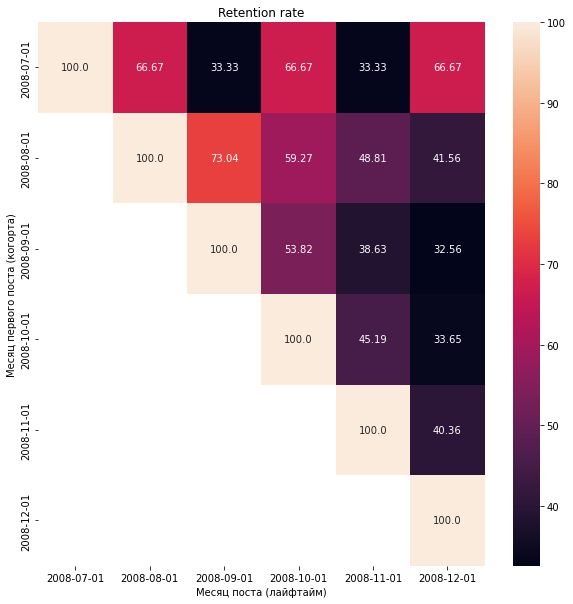

In [12]:
retention = res_8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(10, 10))
sns.heatmap(retention,
            annot=True,
            fmt='')
plt.xlabel('Месяц поста (лайфтайм)')
plt.ylabel('Месяц первого поста (когорта)')
plt.title('Retention rate')
plt.show()

В июльской когорте Retention Rate то падает, то растет, так как размер когорты очень маленький – 3 человека. Stack Overflow начал работать в августе 2008, июль был как приватный тестовый месяц для создателей сайта. У остальных когорт аномалии не наблюдаются.

### Задание 9 <a name='task_9'></a>

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [13]:
query_9 = '''
WITH posts_count_by_month AS (
    SELECT
        EXTRACT(MONTH FROM creation_date) AS creation_month,
        COUNT(id) AS posts_count
    FROM stackoverflow.posts
    WHERE creation_date >= '2008-09-01' AND creation_date < '2009-01-01'
    GROUP BY creation_month
)

SELECT
    creation_month,
    posts_count,
    ROUND((posts_count::numeric / (LAG(posts_count) OVER(ORDER BY creation_month)) - 1) * 100, 2) AS percentage
FROM posts_count_by_month

'''

res_9 = pd.read_sql_query(query_9, con=engine)
res_9

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


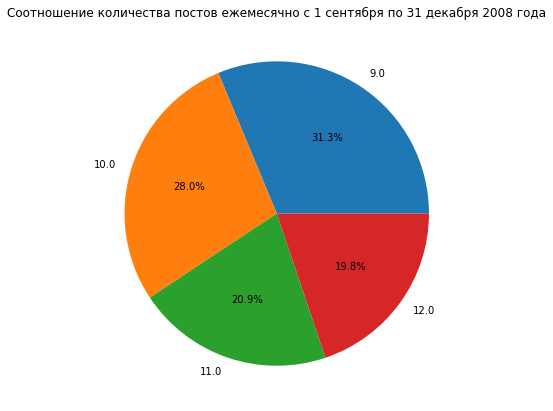

In [14]:
plt.figure(figsize=(7, 7))
plt.pie(res_9['posts_count'], labels=res_9['creation_month'], autopct='%1.1f%%')
plt.title('Соотношение количества постов ежемесячно с 1 сентября по 31 декабря 2008 года');

Количество постов с каждым месяцем падает, наиболее сильное падение произошло в ноябре.

### Задание 10 <a name='task_10'></a>

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [15]:
query_10 = '''
SELECT
    DISTINCT
    EXTRACT(WEEK FROM creation_date) AS week_creation,
    LAST_VALUE(creation_date) OVER(PARTITION BY EXTRACT(WEEK FROM creation_date) ORDER BY creation_date 
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
FROM stackoverflow.posts
WHERE EXTRACT(MONTH FROM creation_date) = 10 AND user_id = (
    SELECT
        user_id
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY COUNT(*) DESC
    LIMIT 1
)
'''

pd.read_sql_query(query_10, con=engine)

,week_creation,last_value
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


# Общий вывод <a name='general_conclusion'></a>

* В сентябре пик просмотров постов, скорее всего это связано с началом учебы. Далее количество просмотров постов постепенно уменьшается

* Некоторые пользователи указывали имя без фамилии, что и привело к большому количеству уникальных пользователей на одно имя пользователя

* Есть посты в августе, хотя пользователи зарегистрировались в сентябре. Может быть это связано с тем, что раньше можно было добавлять посты без регистрации

* Бывает, что пользователи создают посты, которые никто не смотрит

* Пользователи, опубликовавшие более 120 постов в августе, в среднем делали 5 и более постов в день

* В первую неделю декабря в среднем активны 2 дня – не то время, когда пользователи часто пользуются платформой

* В июльской когорте Retention Rate то падает, то растет, так как размер когорты очень маленький – 3 человека, все потому что в этом месяце проводился приватный тест. Далее аномалии не наблюдаются 

* Количество постов с каждым месяцем падает, наиболее сильное падение произошло в ноябре